# <a id='toc1_'></a>[Проект: Исследование посетителей супермаркета](#toc0_)

## <a id='toc1_1_'></a>[Описание проекта:](#toc0_)
Есть супермаркет и с помощью членских карт мы получаем некоторые базовые данные о своих клиентах, такие как идентификатор клиента, возраст, пол, годовой доход и рейтинг расходов.
Рейтинг расходов — это показатель, который вы присваиваете клиенту на основе заданных вами параметров, таких как поведение клиента и данные о покупках.

## <a id='toc1_2_'></a>[Цель исследования:](#toc0_)
Провести комплексный многоаспектный анализ данных о посетителях супермаркета с целью выявления скрытых закономерностей в демографических характеристиках, уровне дохода и покупательском поведении. Исследование включает сегментацию клиентов, изучение взаимосвязей между ключевыми переменными (возраст, доход, затраты и пол) и разработку прогностических моделей для поддержки решений в маркетинге и развития клиентской базы.

Источник данных: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

---
## <a id='toc1_3_'></a>[Вопросы](#toc0_)
1. На какие сегменты можно разделить клиентов супермаркета с использованием оценки возраста и расходов?
2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?
3. Как пол влияет на распределение доходов и показателя расходов?
4. Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?
5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?

**Содержание:**<a id='toc0_'></a>    
- [Проект: Исследование посетителей супермаркета](#toc1_)    
  - [Описание проекта:](#toc1_1_)    
  - [Цель исследования:](#toc1_2_)    
  - [Вопросы](#toc1_3_)    
- [Обзор данных](#toc2_)    
- [Предобработка данных](#toc3_)    
- [Визуализация данных](#toc4_)    
- [Разделение клиентов супермаркета на сегменты](#toc5_)    
- [Зависимости между возрастом, доходом и тратами клиентов](#toc6_)    
- [Влияние пола на распределение доходов и показателя расходов](#toc7_)    
- [Создание прогностической модели для оценки показателя расходов на основе возраста, уровня дохода и пола](#toc8_)    
- [Аномалии и выбросы в данных](#toc9_)    
- [Вывод](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Импорт библиотек:

In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# <a id='toc2_'></a>[Обзор данных](#toc0_)

Чтение данных:

In [338]:
# чтение данных
df = pd.read_csv('data\mall_customers.csv', sep = ',')

# определение функции
def df_diagnostics(df1):
    # основные характеристики столбцов
    diag = pd.DataFrame({
        'dtypes': df1.dtypes,
        'count': df1.count(),
        'unique': df1.nunique(),
        'nan_count': df1.isnull().sum(),
        'nan_%': df1.isnull().sum() / df1.shape[0] * 100})

    metrics = {
        'mean': lambda s: s.mean(),
        'median': lambda s: s.median(),
        'min': lambda s: s.min(),
        'max': lambda s: s.max()}

    # метрики только для числовых столбцов
    numeric_cols = df1.select_dtypes(include=[np.number]).columns
    for metric, func in metrics.items():
        diag[metric] = [func(df1[col]) if col in numeric_cols else np.nan
                        for col in df1.columns]

    # количество дублирующих строк в df
    duplicates_count = df1.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count)

    # df с градиентной подсветкой, форматированием и округлением чисел
    return (diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)
            .format("{:.2f}", subset=diag.select_dtypes(include=[np.number]).columns))

Обзор таблицы:


In [339]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Диагностика данных:


In [340]:
df_diagnostics(df)

Количество дублирующих строк: 0


,dtypes,count,unique,nan_count,nan_%,mean,median,min,max
CustomerID,int64,200.00,200.00,0.00,0.00,100.50,100.50,1.00,200.00
Gender,object,200.00,2.00,0.00,0.00,nan,nan,nan,nan
Age,int64,200.00,51.00,0.00,0.00,38.85,36.00,18.00,70.00
Annual Income (k$),int64,200.00,64.00,0.00,0.00,60.56,61.50,15.00,137.00
Spending Score (1-100),int64,200.00,84.00,0.00,0.00,50.20,50.00,1.00,99.00


Диагностика данных в таблице показала:
- дублирующих строк нет
- имена полей требуется привести в порядок!
- типы данных соответствуют
- все клиенты уникальные
- пропусков данных в полях нет

---
# <a id='toc3_'></a>[Предобработка данных](#toc0_)

Приведём имена столбцов в порядок:

In [341]:
# зададим новые имена
df.columns = ['customer_id','gender','age','annual_income_k$','spending_score']

`Вывод:` во время предобработки данных были приведены в порядок имена столбцов.

---
# <a id='toc4_'></a>[Визуализация данных](#toc0_)

Определим функции для построения графиков:

In [342]:
def plot_regplot(data, x_column, y_column, title, xlabel, ylabel,
                 hue_column=None, legend_title=None, figsize=(6, 4)):
    """Построение графика распределения scatter"""

    plt.figure(figsize=figsize)
    ax = plt.gca()

    if hue_column is not None: # с группировкой
        # Ручной цикл по категориям
        for category in data[hue_column].unique():
            subset = data[data[hue_column] == category]
            sns.regplot(x=x_column, y=y_column, data=subset,
                        label=category, ax=ax)

        # Название легенды: явно заданное или имя столбца
        legend_title = legend_title or hue_column
        plt.legend(title=legend_title)

    else: # без группировки
        sns.regplot(x=data[x_column], y=data[y_column],
                    line_kws={"color": "red"}, ax=ax)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()

Диаграммы распределения значений полей:

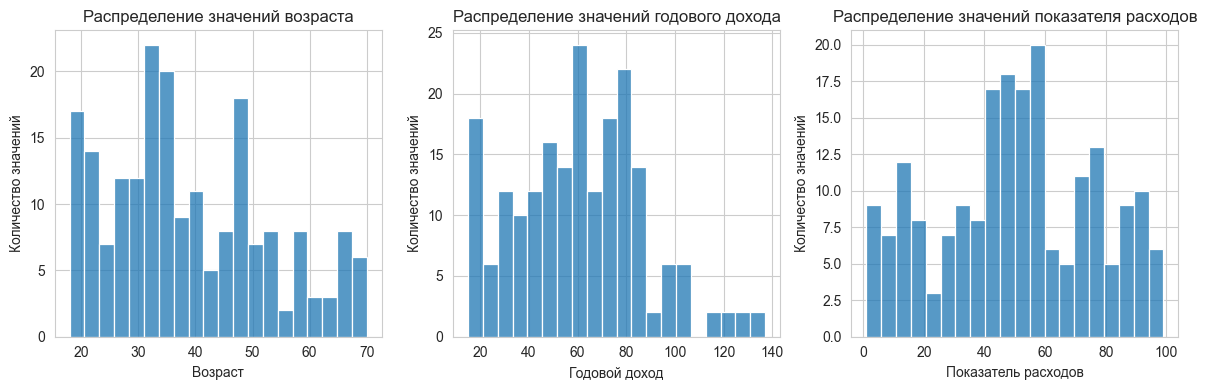

In [343]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df['age'], bins=20)
plt.title("Распределение значений возраста")
plt.xlabel("Возраст"), plt.ylabel("Количество значений")

plt.subplot(1, 3, 2)
sns.histplot(df['annual_income_k$'], bins=20)
plt.title("Распределение значений годового дохода")
plt.xlabel("Годовой доход"), plt.ylabel("Количество значений")

plt.subplot(1, 3, 3)
sns.histplot(df['spending_score'], bins=20)
plt.title("Распределение значений показателя расходов")
plt.xlabel("Показатель расходов"), plt.ylabel("Количество значений")

plt.tight_layout()
plt.show()

Диаграмма распределения значений по половому признаку:

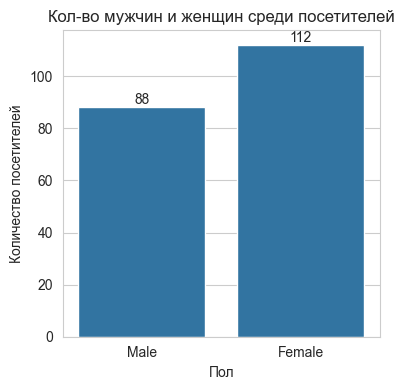

In [344]:
# Строим график баров
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=df, x='gender')
ax.bar_label(ax.containers[0])
plt.title('Кол-во мужчин и женщин среди посетителей')
plt.xlabel('Пол')
plt.ylabel('Количество посетителей')
plt.tight_layout()

График зависимости годового дохода от возраста:

Коэффициент корреляции: -0.01


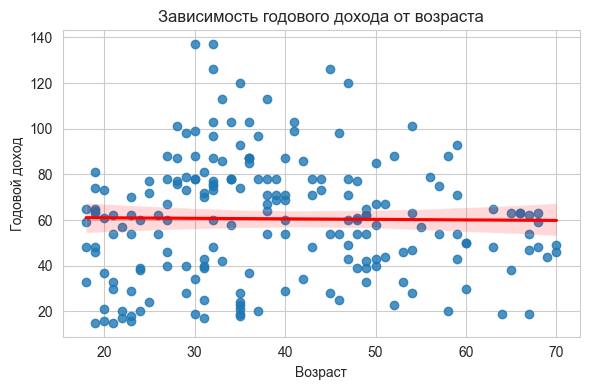

In [345]:
# Расчёт корреляции
correlation = df[["age", "annual_income_k$"]].corr().iloc[0, 1]
print(f"Коэффициент корреляции: {correlation:.2f}")

# Строим график
plot_regplot(data=df, x_column="age", y_column="annual_income_k$",
             title="Зависимость годового дохода от возраста",
             xlabel="Возраст", ylabel="Годовой доход")

График зависимости показателя расходов от возраста:

Коэффициент корреляции: -0.33


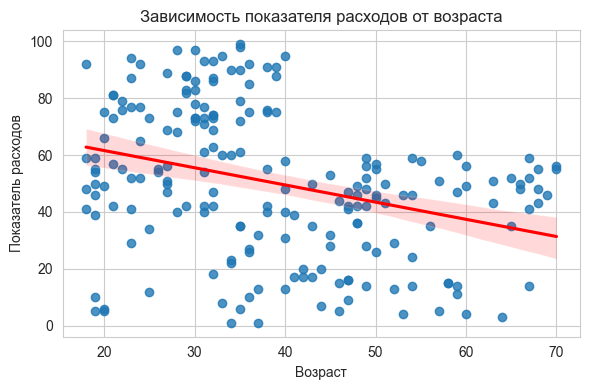

In [346]:
# Расчёт корреляции
correlation = df[["age", "spending_score"]].corr().iloc[0, 1]
print(f"Коэффициент корреляции: {correlation:.2f}")

# Строим график
plot_regplot(data=df, x_column="age", y_column="spending_score",
             title="Зависимость показателя расходов от возраста",
             xlabel="Возраст", ylabel="Показатель расходов")

График зависимости показателя расходов от годового дохода:

Коэффициент корреляции: 0.01


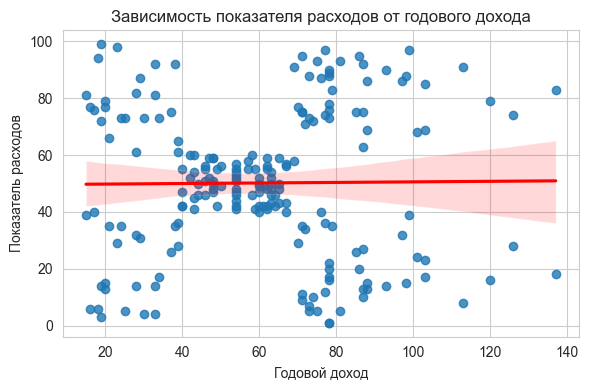

In [347]:
# Расчёт корреляции
correlation = df[["annual_income_k$", "spending_score"]].corr().iloc[0, 1]
print(f"Коэффициент корреляции: {correlation:.2f}")

# Строим график
plot_regplot(data=df, x_column="annual_income_k$", y_column="spending_score",
             title="Зависимость показателя расходов от годового дохода",
             xlabel="Годовой доход", ylabel="Показатель расходов")

График распределения годового дохода в зависимости от возраста и пола:

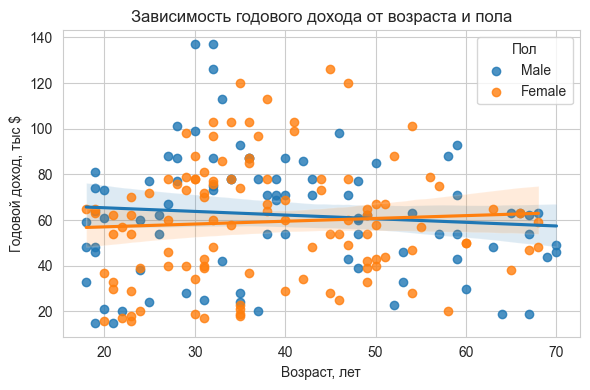

In [348]:
plot_regplot(data=df, x_column='age', y_column='annual_income_k$', hue_column='gender',
             title='Зависимость годового дохода от возраста и пола', legend_title='Пол',
             xlabel='Возраст, лет', ylabel='Годовой доход, тыс $')

Обратим внимание на то, что у женщин годовой доход с увеличением возраста немного увеличивается, а у мужчин немного снижается.

График распределения показателя расходов в зависимости от возраста и пола:

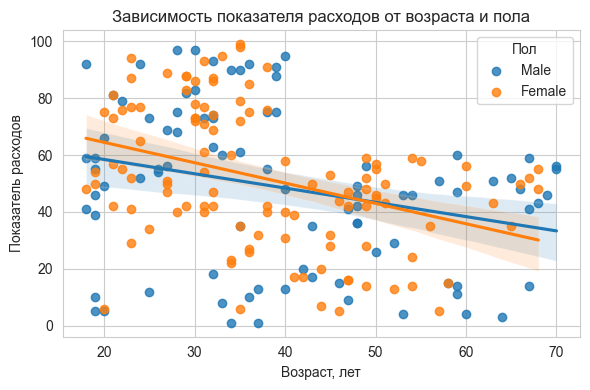

In [349]:
plot_regplot(data=df, x_column='age', y_column='spending_score', hue_column='gender',
             title='Зависимость показателя расходов от возраста и пола', legend_title='Пол',
             xlabel='Возраст, лет', ylabel='Показатель расходов')

Обратим внимание на то, что с увеличением возраста у женщин показатель расходов снижается быстрее.

График распределения показателя расходов в зависимости от годового дохода и пола:

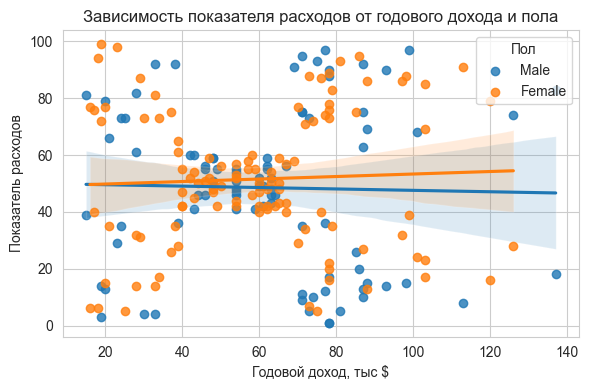

In [350]:
plot_regplot(data=df, x_column='annual_income_k$', y_column='spending_score',
             title='Зависимость показателя расходов от годового дохода и пола',
             hue_column='gender', legend_title='Пол', xlabel='Годовой доход, тыс $',
             ylabel='Показатель расходов')

Обратим внимание на то, что с увеличением годового дохода у мужчин показатель расходов незначительно снижается, а у женщин он незначительно растёт.

# <a id='toc5_'></a>[Разделение клиентов супермаркета на сегменты](#toc0_)

Для сегментирования клиентов супермаркета выполним разделение клиентов на сегменты с помощью кластеризации методом `К-mean`

Определения функций для определения и построения кластеров:

In [351]:
def selecting_number_clusters(transf, n_clusters=range(2, 9), init='k-means++',
                            n_init='auto', tol=0.0001, max_iter=300,
                            algorithm='lloyd', random_state=None):
    """Определение оптимального числа кластеров по графику инерции"""
    n_init = 1 if init not in ['k-means++', 'random'] else n_init

    # Расчет инерции для каждого числа кластеров
    inertia = [KMeans(n_clusters=k, init=init, n_init=n_init, tol=tol,
               max_iter=max_iter, algorithm=algorithm,
               random_state=random_state).fit(transf).inertia_
               for k in n_clusters]

    # Построение графика
    plt.figure(figsize=(6, 4))
    plt.plot(n_clusters, inertia, marker='o')

    plt.title("Зависимость инерции от количества кластеров")
    plt.xlabel("Число кластеров")
    plt.ylabel("Инерция")
    plt.tight_layout()
    plt.show()
    
def build_clusters(df, columns, columns_labels, transf, scaler, n_clusters,
                  init='k-means++', note=None, **kmeans_kwargs):
    """Построение кластеров с визуализацией
    :param df: DataFrame с исходными данными
    :param columns: список из двух имен столбцов для осей
    :param columns_labels: список подписей осей [x_label, y_label]
    :param transf: преобразованные данные для обучения
    :param scaler: используемый scaler для обратного преобразования
    :param n_clusters: количество кластеров
    :param init: метод кластеризации
    :param note: дополнительная информация для заголовка
    :param kmeans_kwargs: дополнительные параметры для KMeans"""

    # Настройки модели
    kmeans_params = {'n_clusters': n_clusters, 'init': init,
        'n_init': 1 if init not in ['k-means++', 'random'] else 'auto',
        **kmeans_kwargs}

    # Обучение модели
    kmeans = KMeans(**kmeans_params).fit(transf)
    labels = kmeans.labels_
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    def _create_meshgrid(data, h=0.5):
        x_min, x_max = data[columns[0]].min()-1, data[columns[0]].max()+1
        y_min, y_max = data[columns[1]].min()-1, data[columns[1]].max()+1
        return np.meshgrid(np.arange(x_min, x_max, h),
                          np.arange(y_min, y_max, h))

    # Построение сетки и предсказание
    xx, yy = _create_meshgrid(df)
    Z = kmeans.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Построение графика
    plt.figure(figsize=(6, 4))
    # Области кластеров
    plt.contourf(xx, yy, Z, alpha=0.4)
    # Исходные данные
    plt.scatter(df[columns[0]], df[columns[1]], c=labels, s=30, edgecolor='k')
    # Центроиды
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100,
               c='red', label='Центроиды', edgecolor='k')

    title = f'Кластеризация ({n_clusters} кластера)' + (f'\n{note}' if note else '')
    plt.title(title)
    plt.xlabel(columns_labels[0])
    plt.ylabel(columns_labels[1])
    plt.legend()
    plt.tight_layout()
    plt.show()

Сегментация с использованием оценки возраста и расходов:

Выполним подготовку данных и выведем график зависимости инерции от количества кластеров

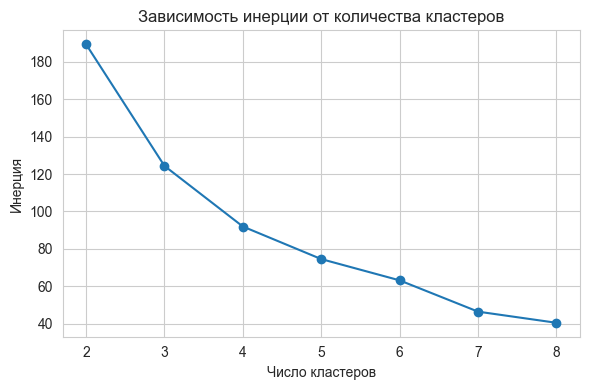

In [352]:
spend_features = df[['age', 'spending_score']].values
spend_scaler = StandardScaler()
spend_transf = spend_scaler.fit_transform(spend_features)

selecting_number_clusters(transf = spend_transf)

Оптимально разделить посетителей на 3 сегмента. Альтернативно можно разделить также на 4 и 5 сегментов, но в этом случае сегментация даёт сегменты с делением клиентов по показателю расходов на небольшие диапазоны и так стоит делить посетителей только в случае если это оправдано.

Разделение посетителей на 3 сегмента:

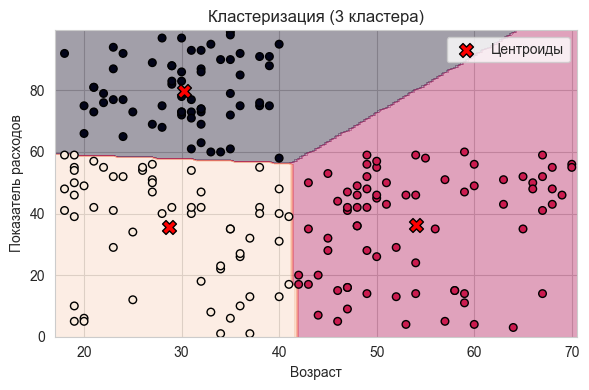

In [353]:
build_clusters(df= df, columns = ['age', 'spending_score'], transf = spend_transf,
               columns_labels = ['Возраст', 'Показатель расходов'],
               scaler = spend_scaler, n_clusters = 3, random_state = 34)

In [354]:
# в новый столбец запишем номер сегмента
df['segment'] = (df.apply(lambda x:
                1 if (x['age'] <= 40) & (x['spending_score'] <= 60) else
                2 if (x['age'] <= 40) & (x['spending_score'] > 60) else 3
                , axis=1))

# для каждого сегмента посчитаем медианные значения
grouped = df.groupby('segment').agg(
    age = ('age', 'median'),
    spending = ('spending_score', 'median'),
    annual = ('annual_income_k$', 'median'),
    percent = ('customer_id', lambda x: len(x) / len(df) * 100),
    ).reset_index()

# переименуем столбцы
grouped.rename(columns={'segment': 'Сегмент', 'age': 'Возраст, лет',
            'spending': 'Показатель расходов', 'annual': 'Годовой доход, тыс.$',
            'percent': 'Удельный вес группы, %'}, inplace=True)

# выведем таблицу
grouped

,Сегмент,"Возраст, лет",Показатель расходов,"Годовой доход, тыс.$","Удельный вес группы, %"
0,1,28.5,41.5,60.0,30.0
1,2,30.5,79.0,73.5,31.0
2,3,51.0,42.0,55.5,39.0


`Вывод:` Присвоим трём нашим сегментам имена и опишем их:

- Сегмент 1: `Молодые с низким расходом` - Возраст от 0 до 42 лет и показатель расходов от 0 и до 60.
- Сегмент 2: `Молодые с высоким расходом` - Возраст от 0 до 42 лет и показатель расходов от 60 и выше.
- Сегмент 3: `Люди в возрасте` - Возраст от 42 лет и выше и показатель расходов любой.

# <a id='toc6_'></a>[Зависимости между возрастом, доходом и тратами клиентов](#toc0_)

Корреляционная матрица между возрастом, уровнем годового дохода и показателем расходов:

In [355]:
corr_matrix = df[['age', 'annual_income_k$', 'spending_score']].corr()
print("Корреляционная матрица:\n", corr_matrix)

Корреляционная матрица:
                        age  annual_income_k$  spending_score
age               1.000000         -0.012398       -0.327227
annual_income_k$ -0.012398          1.000000        0.009903
spending_score   -0.327227          0.009903        1.000000


Расшифровка корреляционной матрицы:
- Возраст (age) и Годовой Доход (Annual Income):
Коэффициент корреляции равен -0.012398. Это значит, что практически отсутствует какая-либо значимая связь между возрастом и годовым доходом. С увеличением возраста доходы снижаются не значительно.

- Возраст (age) и Показатель Расходов (Spending Score):
Коэффициент корреляции составляет -0.327227, что свидетельствует о слабой отрицательной зависимости. Это означает, что с увеличением возраста расходы немного снижаются. То есть, чем старше человек, тем ниже его уровень трат.

- Годовой Доход (Annual Income) и Показатель Расходов (Spending Score):
Значение корреляции равно 0.009903, что также указывает на почти полное отсутствие связи. Получается, что увеличение доходов слабо связано с ростом уровня расходов. Люди с большим доходом не обязательно больше тратят.

Тепловая карта на основании корреляционной матрицы:

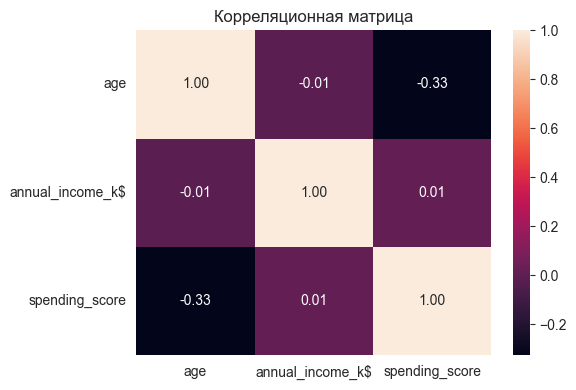

In [356]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Корреляционная матрица")
plt.tight_layout()

`Вывод:`

- Между возрастом и годовым доходом зависимость практически отсутствует. С увеличением возраста доходы снижаются не значительно.
- Между возрастом и показателем расходов зависимость является слабой отрицательной. Это обозначает, что с увеличением возраста расходы немного снижаются.
- Между годовым доходом и показателем расходов зависимость практически полностью отсутствует. Увеличение расходов слабо связано с ростом уровня доходов. Люди с большим доходом не обязательно больше тратят.

# <a id='toc7_'></a>[Влияние пола на распределение доходов и показателя расходов](#toc0_)

Сводная таблица по половому признаку:

In [357]:
print("Средние значения `годового дохода` и `показателя расходов` по полу:")
print(df.groupby('gender')[['annual_income_k$', 'spending_score']].mean())

Средние значения `годового дохода` и `показателя расходов` по полу:
        annual_income_k$  spending_score
gender                                  
Female         59.250000       51.526786
Male           62.227273       48.511364


Разъяснение показателей в таблице:
1. Годовой доход:
   - Женщины имеют средний годовой доход около 59,25 тысяч долларов.
   - Мужчины имеют немного больший средний доход — примерно 62,23 тысячи долларов.
   
   Это означает, что мужчины зарабатывают чуть больше, чем женщины, хотя разница невелика.

2. Уровень расходов (по шкале от 1 до 100):
   - Средний уровень расходов среди женщин составляет 51,53.
   - Среди мужчин этот показатель ниже — 48,51.

   Таким образом, женщины тратят немного больше денег, чем мужчины.

Детальная статистика распределения доходов и расходов по половому признаку:

In [358]:
print("Детальная статистика:")
print(df.groupby('gender')[['annual_income_k$', 'spending_score']].describe())

Детальная статистика:
       annual_income_k$                                                  \
                  count       mean        std   min    25%   50%    75%   
gender                                                                    
Female            112.0  59.250000  26.011952  16.0  39.75  60.0  77.25   
Male               88.0  62.227273  26.638373  15.0  45.50  62.5  78.00   

              spending_score                                                    
          max          count       mean       std  min   25%   50%   75%   max  
gender                                                                          
Female  126.0          112.0  51.526786  24.11495  5.0  35.0  50.0  73.0  99.0  
Male    137.0           88.0  48.511364  27.89677  1.0  24.5  50.0  70.0  97.0  


Определим функцию для построения диаграммы скрипичного ключа:


Скрипичная диаграмма с распределением доходов по полу:

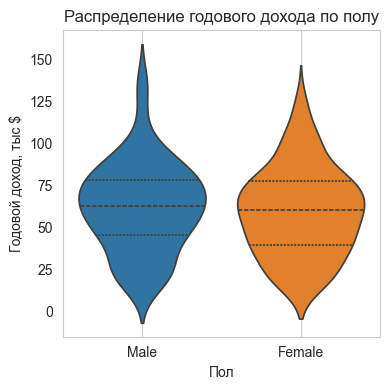

In [359]:
# Сортируем категории по медиане
x_column = 'gender'
y_column = 'annual_income_k$'
order = (df.groupby(x_column)[y_column]
         .median()
         .sort_values(ascending=False).index)

plt.figure(figsize=(4, 4))
sns.violinplot(data=df, x=x_column, y=y_column,
               hue=x_column, order=order, inner='quartile')
plt.title('Распределение годового дохода по полу')
plt.xlabel("Пол")
plt.ylabel("Годовой доход, тыс $")
plt.grid()
plt.tight_layout()

Скрипичная диаграмма с распределением расходов по полу:

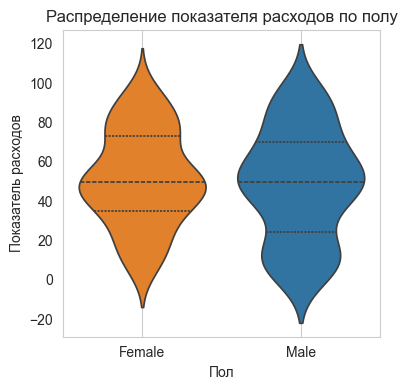

In [360]:
# Сортируем категории по медиане
x_column = 'gender'
y_column = 'spending_score'
order = (df.groupby(x_column)[y_column]
         .median()
         .sort_values(ascending=False).index)

plt.figure(figsize=(4, 4))
sns.violinplot(data=df, x=x_column, y=y_column,
               hue=x_column, order=order, inner='quartile')
plt.title('Распределение показателя расходов по полу')
plt.xlabel("Пол")
plt.ylabel("Показатель расходов")
plt.grid()
plt.tight_layout()

`Вывод:`

**Влияние пола на годовой доход:** Женщины имеют средний годовой доход около 59,25 тысяч долларов. Мужчины имеют немного больший средний доход — примерно 62,23 тысячи долларов. Это означает, что мужчины зарабатывают чуть больше, чем женщины, хотя разница невелика.

**Влияние пола на показатель расходов:** Средний уровень расходов среди женщин составляет 51,53. Среди мужчин этот показатель ниже — 48,51. Таким образом, женщины тратят немного больше денег, чем мужчины.

**В итоге:** Несмотря на то, что мужчины в среднем зарабатывают больше, женщины склонны тратить больше относительно своего дохода. Это может указывать на различия в покупательских привычках или предпочтениях между полами.

# <a id='toc8_'></a>[Создание прогностической модели для оценки показателя расходов на основе возраста, уровня дохода и пола](#toc0_)

Выполним предобработку данных:

In [361]:
# Копия df
data_ml = df.copy()

# Кодирование переменной gender
data_ml['gender'] = data_ml['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Выбор признаков (X) и целевой переменной (y)
X = data_ml[['age', 'annual_income_k$', 'gender']]
y = data_ml['spending_score']

# Разбивка на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация признаков для линейной регрессии
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

---
Базовая модель: Линейная регрессия

In [362]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

print("Линейная регрессия:")
print("R²:", r2_score(y_test, y_pred_lin))
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))

Линейная регрессия:
R²: 0.025478181600745997
MAE: 18.151395326685105
RMSE: 21.924259205438346


Показатели модели линейной регрессии указывают на её низкую точность прогнозирования показателя расходов на основе выбранных факторов (возраст, уровень дохода и пол):

- Коэффициент детерминации R²: значение 0.02 означает, что всего лишь около 2% вариации целевой переменной объясняется моделью. Это крайне низкий показатель.
  
- Средняя абсолютная ошибка (MAE) равна примерно 18 единицам шкалы Spending Score. Это значит, что в среднем предсказания отклоняются от реальных значений на 18 пунктов.
  
- Корень среднеквадратичной ошибки (RMSE) составляет почти 22 единицы, что также подтверждает значительную ошибку прогноза.

Модель плохо справляется с задачей — она объясняет менее 2% изменений в расходах клиентов, а её прогнозы часто далеки от истинных значений. Основные признаки, вероятно, недостаточно сильно связаны с целевым показателем.

---
Сложная модель: Random Forest Regressor

In [363]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

print("Random Forest Regression:")
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest Regression:
R²: 0.07749115042457333
MAE: 12.371279166666667
RMSE: 21.331157140778448


Модель случайного леса (Random Forest) показывает немного лучшие результаты по сравнению с линейной регрессией, но всё ещё остаётся недостаточно точной:

- Коэффициент детерминации R²: 0.08 означает, что модель объясняет около 8% вариаций в Spending Score. Хотя это лучше, чем у линейной регрессии, этот результат всё равно считается низким.
  
- Средняя абсолютная ошибка (MAE) уменьшилась до 12 единиц, что говорит о меньшем среднем отклонении прогнозов от фактических значений.
  
- Корень среднеквадратичной ошибки (RMSE) остался практически таким же — около 21 единицы, что свидетельствует о значительной ошибке в прогнозировании.

Случайный лес работает чуть лучше линейной регрессии, уменьшая среднюю ошибку прогноза. Однако модель всё равно остаётся ненадёжной, поскольку она объясняет лишь небольшую долю изменений в показателях расходов.

---
Анализ важности признаков для Random Forest:

In [364]:
importances = rf_reg.feature_importances_
feature_names = X.columns

print("Важность признаков (Random Forest):")
for name, importance in zip(feature_names, importances):
    print(f"Признак: {name}, Важность: {importance:.3f}")

Важность признаков (Random Forest):
Признак: age, Важность: 0.494
Признак: annual_income_k$, Важность: 0.474
Признак: gender, Важность: 0.032


Анализ важности признаков для модели случайного леса (Random Forest) показывает вклад каждого признака в предсказание Spending Score:

- Возраст (age): важность 0.49 указывает, что возраст является самым влиятельным фактором среди всех рассматриваемых признаков. Он оказывает наибольшее влияние на прогнозируемые расходы.
  
- Годовой доход (Annual Income): важность 0.47 также делает его важным признаком, который значительно влияет на прогноз.
  
- Пол (gender): важность 0.03 демонстрирует, что пол играет наименьшую роль в предсказании расходов, его влияние минимально.

---
График для линейной регрессии истинного и предсказанного значения:

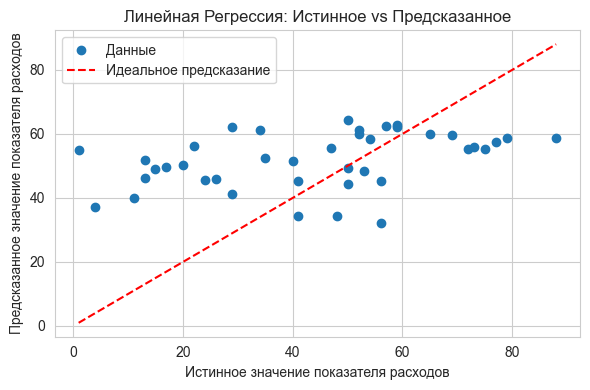

In [365]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_lin, label='Данные')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', label='Идеальное предсказание')

plt.title("Линейная Регрессия: Истинное vs Предсказанное")
plt.xlabel("Истинное значение показателя расходов")
plt.ylabel("Предсказанное значение показателя расходов")
plt.legend()
plt.tight_layout()

График истинного и предсказанного значения отображает соответствие между реальными и предсказанными значениями Spending Score, полученными с помощью модели линейной регрессии. Красная пунктирная линия представляет идеальную ситуацию, когда предсказанные значения точно совпадают с истинными. Если точки плотно сгруппированы вдоль красной линии, это означает высокую точность модели: предсказания близки к реальным значениям.

Интерпретация графика: В нашем случае точки разбросаны далеко от красной линии, что указывает на слабую корреляцию между предсказаниями и реальностью. Значения метрик R², MAE и RMSE это подтверждают.

---
Кросс-валидация для оценки устойчивости линейной модели

In [366]:
lin_cv_scores = cross_val_score(lin_reg, X_train_scaled, y_train, cv=5, scoring='r2')
print("Кросс-валидация (Линейная регрессия, R²):", lin_cv_scores)

Кросс-валидация (Линейная регрессия, R²): [ 0.14285989 -0.00449044 -0.16108338  0.14920608  0.04561792]


Кросс-валидация используется для оценки устойчивости модели, проверяя её производительность на различных участках данных. В данном случае кросс-валидация была выполнена с использованием 5-кратного разбиения (cv=5), и метрика качества оценивалась через коэффициент детерминации R².

Интерпретация результатов:
- Значение R²: Коэффициент детерминации измеряет долю дисперсии целевой переменной, которую объясняет модель. Значение R² варьируется от 0 до 1, где 1 означает идеальное соответствие модели данным, а 0 — отсутствие связи.
- Устойчивость модели: Важно смотреть на диапазон полученных значений R². Если значения сильно различаются, это может свидетельствовать о нестабильной работе модели на разных частях данных.

`Вывод:`

На основании проведённого анализа нельзя создать надёжную прогностическую модель для оценки показателя расходов исключительно на основе таких факторов, как возраст, уровень дохода и пол. Модель оказывается недостаточно точной для практических целей.

Наиболее значимые факторы, влияющие на прогнозирование показателя расходов:

1. Возраст: самый важный фактор, оказывающий значительное влияние на траты.
2. Годовой доход: также сильно влияет на расходы, хотя чуть меньше, чем возраст.
3. Пол: имеет минимальное влияние на предсказание трат.

**Общий вывод:**
Для улучшения точности модели потребуется включить дополнительные данные и признаки, поскольку выбранные параметры (возраст, доход и пол) недостаточно информативны для точного прогнозирования трат.

# <a id='toc9_'></a>[Аномалии и выбросы в данных](#toc0_)

Определение выбросов для каждой переменной:

In [367]:
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

outliers_age = find_outliers(df['age'])
outliers_income = find_outliers(df['annual_income_k$'])
outliers_score = find_outliers(df['spending_score'])

# вывод аномалий
print("Аномалии в age:")
print(outliers_age)
print("\nАномалии в 'annual_income_k$':")
print(outliers_income)
print("\nАномалии в 'spending_score':")
print(outliers_score)

Аномалии в age:
Series([], Name: age, dtype: int64)

Аномалии в 'annual_income_k$':
198    137
199    137
Name: annual_income_k$, dtype: int64

Аномалии в 'spending_score':
Series([], Name: spending_score, dtype: int64)


Анализ выбросов: Годовой доход (`annual_income_k$`): Выбросы были обнаружены в двух наблюдениях с годовым доходом 137 тысяч долларов. Такие значения могут оказаться существенно больше среднего дохода в выборке и, следовательно, представлять собой выбросы, способные повлиять на модели машинного обучения.

Влияние выбросов на результаты анализа:
Выбросы могут оказывать значительное влияние на различные этапы анализа данных, особенно когда речь идет о моделях машинного обучения. Рассмотрим, каким образом выбросы в годовом доходе могут воздействовать на анализ:

1. Регрессии и предсказания:
   - Линейная регрессия и другие методы регрессии чувствительны к выбросам, поскольку они стремятся минимизировать сумму квадратов ошибок между предсказанными значениями и фактическими. Если в данных есть выбросы, такие точки могут смещать линию регрессии, делая её менее точной для основной массы наблюдений.
   - Для моделей типа Random Forest, хотя они и обладают устойчивостью к выбросам благодаря использованию деревьев решений, выбросы всё же могут повлиять на качество модели. Например, если некоторые деревья в случайном лесе будут строить свои решения вокруг выбросов, итоговая оценка будет хуже.

2. Метрики качества:
   - Коэффициент детерминации R² показывает долю дисперсии целевой переменной, которую объясняет модель. Выбросы могут снижать значение R², поскольку они часто находятся далеко от линии регрессии и увеличивают ошибку модели.
   - Средняя абсолютная ошибка (MAE) и среднеквадратичная ошибка (RMSE) также возрастают из-за выбросов, так как эти метрики измеряют разницу между предсказаниями и истинными значениями, включая выбросы.

3. Кросс-валидация:
   Результаты кросс-валидации показывают нестабильность модели линейной регрессии — значения R² варьируются от положительных до отрицательных, что подтверждает чувствительность модели к выбросам. Это может свидетельствовать о переобучении на тренировочном наборе данных.

Рекомендации:
Для повышения точности анализа рекомендуется либо удалить выбросы перед построением моделей, либо использовать робастные алгоритмы, которые менее подвержены влиянию выбросов (например, методы квантильной регрессии). Также стоит учитывать возможное наличие скрытых факторов, объясняющих высокие доходы, чтобы избежать удаления полезной информации.

`Вывод:` В данных выявлены выбросы в показателях годового дохода, которые могут искажать результаты анализа. Эти выбросы способны негативно влиять на точность моделей машинного обучения, таких как линейная регрессия и даже более устойчивый метод случайного леса. Чтобы улучшить качество анализа, рекомендуется либо исключить выбросы, либо использовать алгоритмы, которые менее восприимчивы к ним, например, квантильную регрессию.

---
# <a id='toc10_'></a>[Вывод](#toc0_)

`Предобработка данных:` во время предобработки данных были приведены в порядок имена столбцов.

**Вопрос 1:** На какие сегменты можно разделить клиентов супермаркета с использованием оценки возраста и расходов?

Клиентов супермаркета на основании оценки возраста и расходов можно разделить на 3 следующих сегмента:

1. Сегмент 1: `Молодые с низким расходом` - В сегмент входят молодые люди до 40 лет с низким уровнем расходов.
2. Сегмент 2: `Молодые с высоким расходом` - В сегмент входят молодые люди до 40 лет с высоким уровнем расходов.
3. Сегмент 3: `Люди в возрасте` - Люди от 40 лет с любым уровнем расходов.

**Рекомендации:**
 
Фокусировка на сегменте 2: Этот сегмент имеет самый высокий показатель расходов 79 и довольно высокую долю в общем количестве клиентов 31%. Для стимулирования роста покупок у данного сегмента можно предложить следующие меры:
   - Создание персонализированных предложений на основе истории покупок.
   - Проведение акций и распродаж, ориентированных именно на этот сегмент.
   - Введение бонусной программы или системы лояльности для удержания и повышения частоты посещений.
   
Развитие сегмента 1: Хотя средний возраст ниже среднего и составляет 28.5 года, этот сегмент также составляет значительную часть аудитории 30%. Можно попробовать увеличить расходы этой группы через:
   - Продвижение товаров, популярных среди молодежи (например, современные гаджеты, спортивные товары).
   - Интерактивные мероприятия, направленные на привлечение молодых людей (конкурсы, розыгрыши).
   - Расширение ассортимента недорогих продуктов, учитывая относительно низкий годовой доход 60K$.

Повышение активности сегмента 3: Средний возраст в данном сегменте самый высокий и составляет 51 год, и хотя доля этого сегмента велика 39%, расходы ниже среднего 42. Рекомендуется:
   - Акцентирование внимания на продуктах, соответствующих интересам пожилых покупателей (здоровое питание, лекарства).
   - Специальные предложения для пенсионеров, такие как скидки в определенные дни недели.
   - Улучшение удобства шопинга для данной возрастной категории (например, дополнительные места отдыха внутри магазина).

**Идеи для дальнейшего анализа:**

1. Анализ корзины покупателя:
   Разделение клиентов по типу приобретаемых товаров поможет лучше понимать потребности каждого сегмента. Например:
   - Выявление основных категорий товаров, покупаемых каждым сегментом.
   - Определение уровня перекрестных продаж между категориями.
   - Поиск возможности расширения ассортимента на основе предпочтений сегментов.

2. Исследование поведенческих паттернов:
   Анализ поведения клиентов внутри магазина позволит выявить ключевые моменты взаимодействия с продуктом и торговой площадкой:
   - Время посещения магазина.
   - Продолжительность пребывания в магазине.
   - Частота покупок.
   - Использование различных каналов покупки (онлайн vs офлайн).

3. Прогнозирование потребительского спроса:
   Построение моделей прогнозирования спроса поможет предугадать поведение клиентов и подготовиться к пиковым нагрузкам:
   - Прогнозирование объемов продаж на ближайшие месяцы/кварталы.
   - Оценка влияния сезонности на покупательское поведение.

4. Создание портретов клиента:
   Более глубокая характеристика каждого сегмента позволит разрабатывать более точные стратегии:
   - Психографические характеристики (интересы, ценности, образ жизни).
   - Социальная активность (использование социальных сетей, участие в общественных мероприятиях).
   - Предпочтительные каналы коммуникации (телефон, email, социальные сети).

---
**Вопрос 2:** Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?

- Между возрастом и годовым доходом зависимость практически отсутствует. С увеличением возраста доходы снижаются не значительно.
- Между возрастом и показателем расходов зависимость является слабой отрицательной. Это обозначает, что с увеличением возраста расходы немного снижаются.
- Между годовым доходом и показателем расходов зависимость практически полностью отсутствует. Увеличение расходов слабо связано с ростом уровня доходов. Люди с большим доходом не обязательно больше тратят.

---
**Вопрос 3:** Как пол влияет на распределение доходов и показателя расходов?

**Влияние пола на годовой доход:** Женщины имеют средний годовой доход около 59,25 тысяч долларов. Мужчины имеют немного больший средний доход — примерно 62,23 тысячи долларов. Это означает, что мужчины зарабатывают чуть больше, чем женщины, хотя разница невелика.

**Влияние пола на показатель расходов:** Средний уровень расходов среди женщин составляет 51,53. Среди мужчин этот показатель ниже — 48,51. Таким образом, женщины тратят немного больше денег, чем мужчины.

**В итоге:** Несмотря на то, что мужчины в среднем зарабатывают больше, женщины склонны тратить больше относительно своего дохода. Это может указывать на различия в покупательских привычках или предпочтениях между полами.

---
**Вопрос 4:** Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?

На основании проведённого анализа нельзя создать надёжную прогностическую модель для оценки показателя расходов исключительно на основе таких факторов, как возраст, уровень дохода и пол. Модель оказывается недостаточно точной для практических целей.

Наиболее значимые факторы, влияющие на прогнозирование показателя расходов:

1. Возраст: самый важный фактор, оказывающий значительное влияние на траты.
2. Годовой доход: также сильно влияет на расходы, хотя чуть меньше, чем возраст.
3. Пол: имеет минимальное влияние на предсказание трат.

**Общий вывод:**
Для улучшения точности модели потребуется включить дополнительные данные и признаки, поскольку выбранные параметры (возраст, доход и пол) недостаточно информативны для точного прогнозирования трат.

---
**Вопрос 5:** Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?

В данных выявлены выбросы в показателях годового дохода, которые могут искажать результаты анализа. Эти выбросы способны негативно влиять на точность моделей машинного обучения, таких как линейная регрессия и даже более устойчивый метод случайного леса. Чтобы улучшить качество анализа, рекомендуется либо исключить выбросы, либо использовать алгоритмы, которые менее восприимчивы к ним, например, квантильную регрессию.